In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from statsmodels.stats.weightstats import ztest

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
df = pd.read_csv("dataset_titanic/train.csv")
cols = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']
df = df[cols + ["Survived"]]

In [6]:
df.isna().sum()
df.head()

,Pclass,Sex,Age,Fare,Embarked,Survived
0,3,male,22.0,7.2500,S,0
1,1,female,38.0,71.2833,C,1
2,3,female,26.0,7.9250,S,1
3,1,female,35.0,53.1000,S,1
4,3,male,35.0,8.0500,S,0


# Features and Target

In [7]:
X = df[cols]
y = df["Survived"]

# Pipeline for numeric, categorical and binary features

In [8]:
numeric_features = ["Age", "Fare"]
categorical_features = ["Pclass", "Embarked"]
binary_features = ["Sex"]

In [9]:
numeric_transformer = Pipeline(
    steps = [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps = [("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))]
)

binary_transformer = Pipeline(
    steps = [("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OrdinalEncoder())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("bin", binary_transformer, binary_features),
    ]
)


# First Experiment: Compare Logistic Regression and Random Forest

In [10]:
seed = 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)
print("X_train = ", X_train.shape)
print("X_test = ", X_test.shape)
print("y_train = ", y_train.shape)
print("y_test = ", y_test.shape)


X_train =  (623, 5)
X_test =  (268, 5)
y_train =  (623,)
y_test =  (268,)


In [11]:
def predict_model(model_pipe, X_train, X_test, y_test):
    model_pipe.fit(X_train, y_train)
    y_pred = model_pipe.predict(X_test)
    score_model = accuracy_score(y_test, y_pred)
    return score_model


#Logistic Regression
pipe_dt = Pipeline(
    [('preprocessor', preprocessor), 
    ('estimator', LogisticRegression(random_state=seed))]
)
#Random Forest
pipe_rn = Pipeline(
    [("preprocessor", preprocessor),
    ("estimator", RandomForestClassifier(random_state=seed))]
)


acc_lr = predict_model(pipe_dt, X_train, X_test, y_test)
acc_rf = predict_model(pipe_rn, X_train, X_test, y_test)

print(acc_lr, acc_rf)

if (acc_lr > acc_rf):
    print("Logistic Regression", acc_lr)
elif (acc_lr < acc_rf):
    print("Random Forest", acc_rf)


0.7798507462686567 0.8171641791044776
Random Forest 0.8171641791044776


# Second Experiment

<h5> Instead of running each model just once, we are going to run them 25 times (with different training and tests datasets) <h5>

In [12]:
results_rn = []
results_lr = []


local_seed = 11
for i in range(25):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=local_seed)
    #Logistic Regression
    pipe_dt = Pipeline(
        [('preprocessor', preprocessor), 
        ('estimator', LogisticRegression(random_state=seed))]
    )
    #Random Forest
    pipe_rn = Pipeline(
        [("preprocessor", preprocessor),
        ("estimator", RandomForestClassifier(random_state=seed))]
    )
    acc_lr = predict_model(pipe_dt, X_train, X_test, y_test)
    acc_rn = predict_model(pipe_rn, X_train, X_test, y_test)
    results_lr.append(acc_lr)
    results_rn.append(acc_rn)
    
    local_seed = local_seed + 10


In [13]:
df_results = pd.DataFrame({"Logistic Regression": results_lr, "Random Forest": results_rn})
df_results.describe()

,Logistic Regression,Random Forest
count,25.000000,25.000000
mean,0.794925,0.813284
std,0.026527,0.020451
min,0.746269,0.776119
25%,0.772388,0.798507
50%,0.794776,0.820896
75%,0.820896,0.832090
max,0.839552,0.843284


In [14]:
if (df_results['Logistic Regression'].mean() > df_results['Random Forest'].mean()):
    print("Logistic Regression")
else:
    print("Random Forest")

# Compare the results at any round
df_results["Logistic Better"] = df_results['Logistic Regression'] > df_results['Random Forest']
df_results["Random Better"] = df_results['Logistic Regression'] < df_results['Random Forest']


Random Forest


In [15]:
df_results = df_results.drop(columns=["Logistic Better", "Random Better"])

In [16]:
for i in range(25):
    if (df_results.loc[i,('Logistic Regression')] > df_results.loc[i,('Random Forest')]):
        df_results.loc[i, ("Aval")] = "Logistic Regression"
    elif (df_results.loc[i,('Logistic Regression')] < df_results.loc[i,('Random Forest')]):
        df_results.loc[i, ("Aval")] = "Random Forest"
    else:
        df_results.loc[i, ("Aval")] = "Equal"

df_results['Aval'].value_counts()
df_results.describe

<bound method NDFrame.describe of     Logistic Regression  Random Forest                 Aval
0              0.764925       0.832090        Random Forest
1              0.772388       0.832090        Random Forest
2              0.746269       0.805970        Random Forest
3              0.820896       0.832090        Random Forest
4              0.768657       0.794776        Random Forest
5              0.776119       0.817164        Random Forest
6              0.820896       0.817164  Logistic Regression
7              0.817164       0.832090        Random Forest
8              0.805970       0.820896        Random Forest
9              0.757463       0.776119        Random Forest
10             0.768657       0.813433        Random Forest
11             0.776119       0.832090        Random Forest
12             0.824627       0.824627                Equal
13             0.809701       0.798507  Logistic Regression
14             0.828358       0.820896  Logistic Regression
15    

# Third Experiment

In [17]:
results_rn = []
results_lr = []


local_seed = 11
for i in range(25):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=local_seed)
    #Logistic Regression
    pipe_dt = Pipeline(
        [('preprocessor', preprocessor), 
        ('estimator', LogisticRegression(random_state=seed))]
    )
    #Random Forest
    pipe_rn = Pipeline(
        [("preprocessor", preprocessor),
        ("estimator", RandomForestClassifier(random_state=seed))]
    )
    acc_lr = predict_model(pipe_dt, X_train, X_test, y_test)
    acc_rn = predict_model(pipe_rn, X_train, X_test, y_test)
    results_lr.append(acc_lr)
    results_rn.append(acc_rn)
    
    local_seed = local_seed + 10

In [18]:
df_3t = pd.DataFrame({"Logistic Regression": results_lr, "Random Forest": results_rn})
df_3t.describe()

,Logistic Regression,Random Forest
count,25.000000,25.000000
mean,0.794925,0.813284
std,0.026527,0.020451
min,0.746269,0.776119
25%,0.772388,0.798507
50%,0.794776,0.820896
75%,0.820896,0.832090
max,0.839552,0.843284


/home/joao/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joao/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


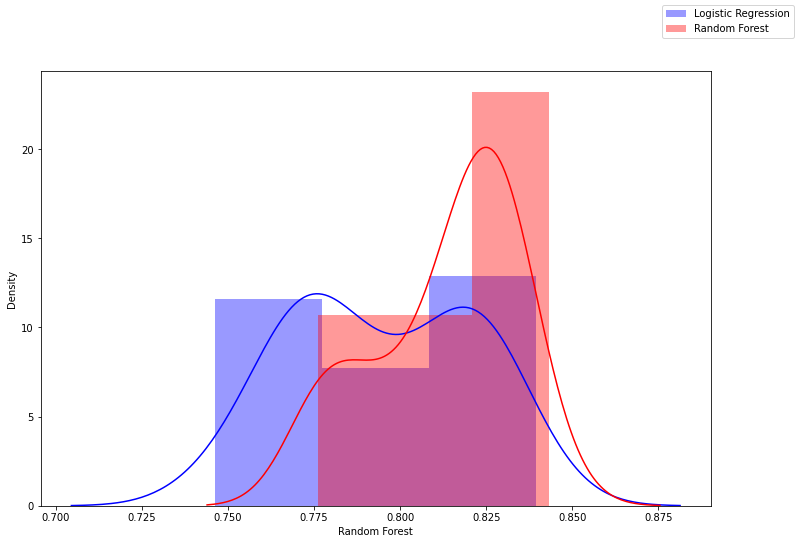

In [19]:
fig = plt.figure(figsize=(12, 8))
ax = sns.distplot(df_3t["Logistic Regression"], label = "Logistic Regression", color = "blue")
ax = sns.distplot(df_3t["Random Forest"], label= "Random Forest", color= "red")
# fig.legend(labels=['Logistic Regression','Random Forest'])
fig.legend()
plt.show()

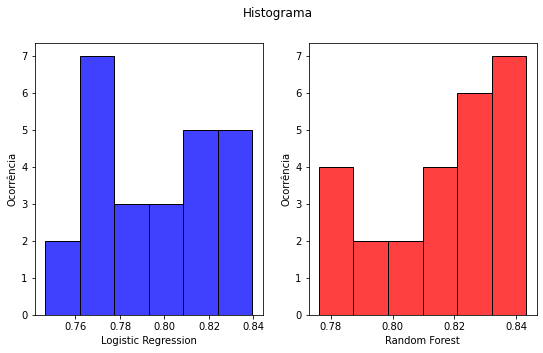

In [20]:
fig = plt.figure(figsize=(9, 5))
fig.suptitle("Histograma")
fig.add_subplot(121)
ax = sns.histplot(df_3t["Logistic Regression"], label = "Logistic Regression", color = "blue")
ax.set_ylabel("Ocorrência")
fig.add_subplot(122)
ax = sns.histplot(df_3t["Random Forest"], label= "Random Forest", color= "red")
ax.set_ylabel("Ocorrência")
plt.show()

In [21]:
alpha = 0.05
z_calc, p_valor = ztest(x1=df_3t["Logistic Regression"], x2 = df_3t["Random Forest"], alternative='two-sided')
z_calc, p_valor

(-2.7404474310073303, 0.006135559610784439)

In [22]:
if p_valor < alpha:
    print("Reject H0! - There is statistical difference between the LR and RN methods in terms of mean accuracies")
else:
    print("Do not reject H0! - Maybe there is no statistical difference between the LR and RN methods in terms of mean accuracies")

Reject H0! - There is statistical difference between the LR and RN methods in terms of mean accuracies
